# Модель, предсказывающая цену за м²

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt


In [15]:
df = pd.read_csv('data.csv')


df['creation_date'] = pd.to_datetime(df['creation_date'])
df['year'] = df['creation_date'].dt.year
df['month'] = df['creation_date'].dt.month
df['day_of_week'] = df['creation_date'].dt.dayofweek

df = df.drop(['underground_list'], axis=1) 

In [17]:
# Выбор признаков и целевой переменной
features = ['author_type', 'location', 'deal_type', 'accommodation_type', 
            'year_of_construction', 'house_material_type', 'living_meters',
            'floors_count', 'month', 'year', 'day_of_week']
target = 'price_per_m2'


X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
# Создание пайплайна 
categorical_features = ['author_type', 'location', 'deal_type', 
                       'accommodation_type', 'house_material_type']
numeric_features = ['year_of_construction', 'living_meters', 
                   'floors_count', 'month', 'year', 'day_of_week']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


In [21]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['year_of_construction',
                                                   'living_meters',
                                                   'floors_count', 'month',
                                                   'year', 'day_of_week']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['author_type', 'location',
                                                   'deal_type',
                                                   'accommodation_type',
                                                   'house_material_type'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [22]:
# Оценка модели
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f} руб/м²")
print(f"R2 Score: {r2:.2f}")


MAE: 1547.54 руб/м²
R2 Score: 0.46


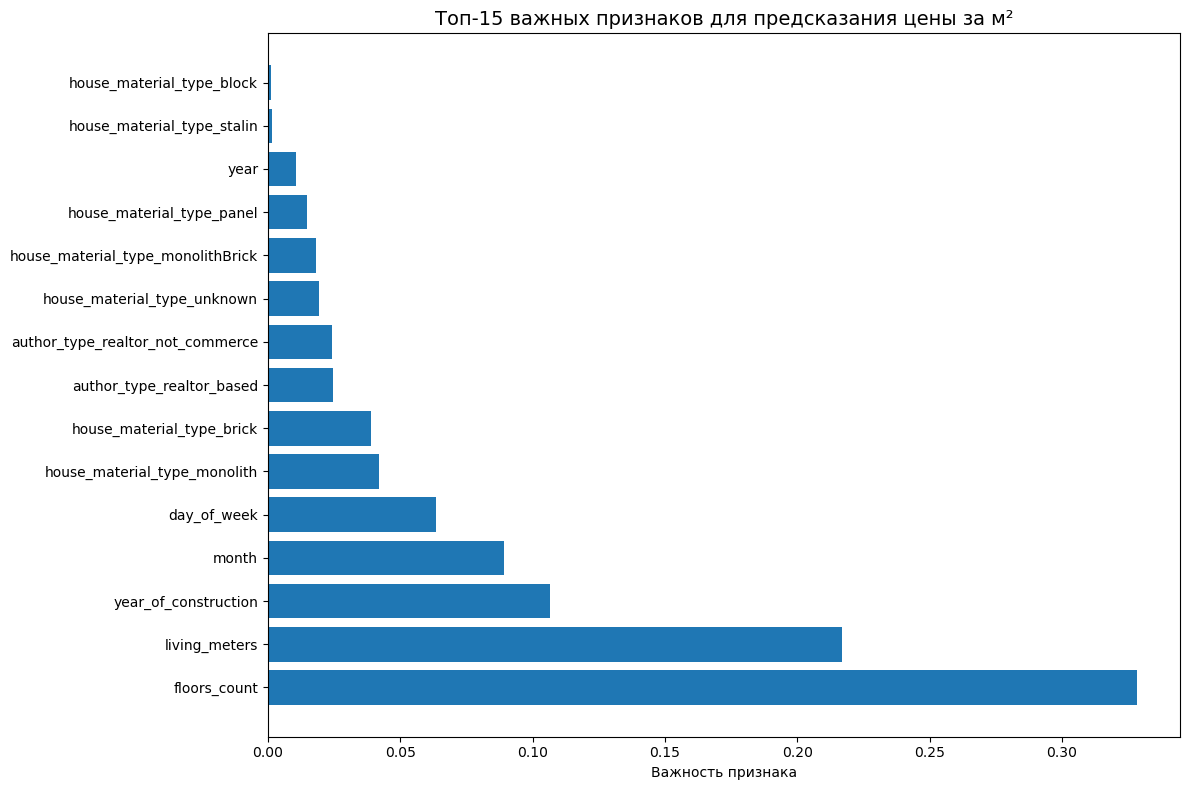

In [23]:

# Визуализация важности признаков
cat_encoder = model.named_steps['preprocessor'].named_transformers_['cat']
cat_features = cat_encoder.get_feature_names_out(categorical_features)
all_features = numeric_features + list(cat_features)

importances = model.named_steps['regressor'].feature_importances_
sorted_idx = importances.argsort()[::-1]

plt.figure(figsize=(12, 8))
plt.barh(np.array(all_features)[sorted_idx][:15], importances[sorted_idx][:15])
plt.title('Топ-15 важных признаков для предсказания цены за м²', fontsize=14)
plt.xlabel('Важность признака')
plt.tight_layout()
plt.show()


In [25]:
# Создаем пример новой квартиры
new_property = pd.DataFrame({
    'author_type': ['realtor_based'],
    'location': ['Москва'],
    'deal_type': ['rent_long'],
    'accommodation_type': ['flat'],
    'year_of_construction': [2020],
    'house_material_type': ['monolithBrick'],
    'living_meters': [60.1],
    'floors_count': [28],
    'month': [7],
    'year': [2025],
    'day_of_week': [1]
})

# Получаем предсказание
predicted_price = model.predict(new_property)[0]
print(f'\nПредсказанная цена за м²: {predicted_price:.2f} руб')


Предсказанная цена за м²: 4110.83 руб
